**환경 변수 로드**: 첫 번째 모델의 “설정하기”를 참조하세요. 

`dotenv` [문서](https://pypi.org/project/python-dotenv/)는 `../.env` 파일을 찾습니다. 해당 파일을 발견하면, 현재 셸의 모든 변수를 덮어쓰며 그곳에서 환경 변수를 로드합니다. 

파일을 찾지 못하면 현재 셸에 있는 변수가 사용됩니다.

In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join(".", ".env"), override=True)

# automatically reload all modules before executing new code. The captures changes in local packages.
%load_ext autoreload
%autoreload 2

## Create React Agent - 사전 구축된 에이전트

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이 과정에서는 [Deep Agent](https://blog.langchain.com/deep-agents/)를 구축하게 됩니다. LangGraph의 ‘사전 구축된’ 에이전트 추상화를 기반으로 구축하여 코드를 크게 간소화할 것입니다. 이 강의에서는 사전 구축된 ReAct 에이전트에 대해 배웁니다. 학습 내용은 다음과 같습니다:
- ReAct 에이전트란 무엇인가
- 구현 기능 및 추가 정보 확인 방법
    - 도구로 에이전트 구축하기
    - 그래프, 상태 및 메시지
    - 도구로 상태 접근 및 수정하기
    - <span style="font-size:0.8em;">🪝</span> 훅! 및 구조화된 응답


### ReAct 에이전트란 무엇인가


<img src="./assets/agent.png"
     style="float:left; max-width:300px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1250px;">
    
LangGraph의 오픈소스 `create_react_agent`([여기 참조](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent)) 추상화를 사용하게 될 것입니다. **ReAct 에이전트**는 “추론과 행동”(ReAct) 프레임워크를 사용하여 사슬형 사고(CoT) 추론과 외부 도구 사용을 결합하는 AI 에이전트입니다. 이 개념은 [ReAct: 언어 모델에서 추론과 행동의 시너지](https://arxiv.org/abs/2210.03629) 논문으로 널리 알려졌습니다. 

이 에이전트는 세 가지 구성 요소로 이루어집니다: 대규모 언어 모델(LLM), 사용 가능한 도구 세트, 지시를 제공하는 프롬프트입니다.

LLM은 루프 방식으로 작동합니다. 각 반복에서 LLM은 사용 가능한 도구 목록을 포함한 컨텍스트를 검토합니다. 도구를 호출할 필요가 있는지 결정합니다. 호출할 도구를 선택하고 도구 호출을 구성합니다. 이 호출은 실행을 위해 도구 노드로 전송됩니다. 도구 노드는 해당 도구를 실행하고 결과(관측값)를 LLM으로 다시 전송합니다. LLM은 관측값을 수신하여 다음 행동을 결정하는 데 활용합니다. 이 루프는 중지 조건이 충족될 때까지 계속됩니다. 일반적으로 에이전트가 더 이상 도구를 호출할 필요가 없다고 판단할 때 중지됩니다.
</div>

<div style="clear:both;"></div>

> 참고: `create_react_agent`는 곧 출시될 V1에서 이동됩니다! LangChain에 포함되며 이름이 단순한 `create_agent`로 변경될 예정입니다.

### LangGraph 사전 구축 `create_react_agent`의 주요 기능

`create_react_agent` 추상화와 함께 제공되는 기능 중 일부를 소개합니다. 본 과정에서는 모든 기능을 활용하지는 않지만, `create_react_agent`를 사용하여 과정을 구축하는 동기를 부여합니다(자세한 내용은 [여기](https://langchain-ai.github.io/langgraph/agents/overview/#what-is-an-agent)에서 확인하세요):

- [메모리 통합](../how-tos/memory/add-memory.md): _단기_ (세션 기반) 및 _장기_ (세션 간 지속적) 메모리에 대한 네이티브 지원으로, 챗봇 및 어시스턴트에서 상태 유지 동작을 가능하게 합니다.
- [인간 개입 제어](../concepts/human_in_the_loop.md): 웹소켓 기반 솔루션과 달리 실시간 상호작용에 국한되지 않고, 실행을 무기한 일시 중지하여 인간 피드백을 기다릴 수 있습니다. 이를 통해 워크플로우의 어느 단계에서든 비동기적 승인, 수정 또는 개입이 가능합니다.
- [스트리밍 지원](../how-tos/streaming.md): 에이전트 상태, 모델 토큰, 도구 출력 또는 결합된 스트림의 실시간 스트리밍을 제공합니다.
- [배포 도구](../tutorials/langgraph-platform/local-server.md): 인프라가 필요 없는 배포 도구를 포함합니다. [**LangGraph 플랫폼**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)은 테스트, 디버깅 및 배포를 지원합니다.
  - [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/): 워크플로우 검사 및 디버깅을 위한 시각적 IDE.
  - [LangSmith](https://smith.langchain.com/): 추적 및 평가 도구입니다.
  - 프로덕션 환경을 위한 다양한 [배포 옵션](https://langchain-ai.github.io/langgraph/concepts/deployment_options.md)을 지원합니다.

`create-react-agent`는 매우 정교하여 다양한 입력 형식을 수용하고 많은 커스터마이징을 허용합니다. 단순한 에이전트-툴 루프일 수도 있고, 프리/포스트 훅 및/또는 구조화된 출력을 통해 커스터마이징할 수도 있습니다.

<div style="display:flex; justify-content:center; align-items:flex-end; gap:40px;">

  <figure style="margin:0; text-align:center; width:250px;">
    <img src="./assets/simple_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
    <figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">단순 에이전트</figcaption>
  </figure>

  <figure style="margin:0; text-align:center; width:250px;">
    <img src="./assets/complex_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
    <figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">복잡한 에이전트</figcaption>
  </figure>

</div>
</div>
<br>

이 과정에서는 간단한 형식을 사용하게 될 것입니다. 다만 과정 후반부에 하위 에이전트 <span style="font-size:20px;">🤖 🤖 🤖</span>을 추가하게 될 것입니다!   

  

#### 도구를 활용한 에이전트 구축

시작하기 위해 간단한 계산기 도구로 에이전트를 만들어 보겠습니다. 구성 방식을 파악한 후 더 자세한 내용을 살펴보겠습니다.


In [2]:
from typing import Annotated, List, Literal, Union

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


@tool
def calculator(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
) -> Union[int, float]:
    """
    두 개의 입력값을 받는 계산기 도구를 정의하세요.

    인수:
        연산(문자열): 수행할 연산(‘더하기’, ‘빼기’, ‘곱하기’, ‘나누기’).
        a(부동소수점 또는 정수): 첫 번째 숫자.
        b(부동소수점 또는 정수): 두 번째 숫자.
        
    반환값:
        result (float 또는 int): 연산 결과
    예시
        나누기: result   = a / b
        빼기: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    return result


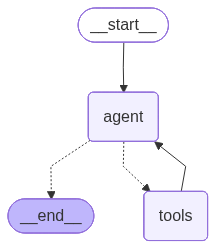

In [3]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from notebooks.utils import format_messages

# Create agent using create_react_agent directly

SYSTEM_PROMPT = "당신은 계산기 사용에 능숙한 유용한 산술 보조자입니다."

model = init_chat_model(model="openai:gpt-4.1-mini", temperature=0.0)
tools = [calculator]

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=SYSTEM_PROMPT,
    #state_schema=AgentState,  # default
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# create_react_agent returns a compiled graph
type(agent)

langgraph.graph.state.CompiledStateGraph

### 그래프, 상태 및 메시지
잠시 후 에이전트를 실행할 예정이지만, 먼저 그래프를 좀 더 자세히 살펴보겠습니다.
`create_react_agent`를 구현하는 코드는 [여기](https://github.com/langchain-ai/langgraph/blob/c37c9cbab3287f0988fabe2b853569a23960e3db/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py)에서 확인할 수 있습니다.  간단한 버전을 직접 만들어보고 싶다면 [Foundation: LangGraph 소개, 모듈 1, 레슨 6, 에이전트](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)를 참고하세요.

**에이전트 정의하기**: 위와 같이 에이전트를 정의할 때 다음을 제공해야 합니다: 모델, 하나 이상의 도구, “시스템” 프롬프트, 그리고 상태 스키마(기본값: <a href="https://github.com/langchain-ai/langgraph/blob/ e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py#L62-L69">
  <code style="color:#0366d6;">AgentState</code>
</a>로, 주로 메시지 목록으로 구성됩니다. ([여기서 통화 세부 정보 참조.](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent))
내부적으로는 위에서 보여준 LangGraph 그래프를 정의하고 컴파일하는 작업입니다. 중요한 세부사항은 tools 노드가 또 다른 사전 구축된 항목인 `ToolNode`라는 점인데, 이에 대한 설명은 [여기](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/tool_node.py#L239-L293)에서 설명됩니다. 툴 노드는 LLM의 메시지에서 식별된 모든 도구를 실행하고 결과를 반환합니다.

**에이전트 호출:**
에이전트를 호출하여 결과를 확인해 보겠습니다!

In [5]:
# Example usage
result1 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

format_messages(result1["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: call_xe8esnEPjYrJB3mTfeLG8yJD                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 곱하기 4.2는 약 13.02입니다.                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**에이전트 호출:**
시퀀스 다이어그램은 모델이 호출될 때 발생하는 과정을 살펴보는 훌륭한 방법입니다.

<div style="display:none">
    머메이드 코드는 향후 사용을 위해 여기에 저장됩니다
```mermaid
sequenceDiagram
    participant U as User
    participant A as LLM
    participant T as Tools
    Note over A: System message<br/>“You are a helpful assistant...”
    U->>A: Initial input,<br/>“What is 3.1 * 4.2?”
    도구 호출이 존재하는 동안 반복
        A->>T: AIMessage(id=“call_123”, tool_calls=[...])
        T-->>A: ToolMessage(tool_call_id=“call_123”, content="xx")
    종료
    A->>U: 최종 상태 반환
```
</div> 

<img src="./assets/agent_sequence_diagram.png"
     style="float:left; max-width:500px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1100px;">
이 예시에서 사용자 입력은 “3.1 * 4.2의 값은 무엇인가요?”입니다. 이 입력은 시스템 프롬프트 및 도구 설명과 함께 LLM으로 전송됩니다.  
<br/>
<p style="margin-bottom:0; margin-top:5px;">LLM은 계산기 도구를 호출해야 한다고 결정합니다. <br/> `messages`에 `AIMessage`를 추가합니다:</p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:0;">
<code class="language-python">AIMessage(
    content="",
    tool_calls=[{“id”: “call_123”,
                 “name”: “calculator”,
                 “args”: {“a”: 3.1, “b”: 4.2, ‘operation’: “multiply”}}])</code></pre>   
</code></pre>
<br/>
<p style="margin-bottom:0;">도구 노드는 AIMessage를 수신하고 모든 도구 호출을 처리합니다. tool_call_ids를 추적합니다. `messages`에 ToolMessage로 응답합니다: </p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:10px;">
<code class="language-python">ToolMessage(
    content="13.02",         # 도구 실행 결과.
    tool_call_id="call_123")  # AIMessage.tool_calls의 ID와 일치.
</code></pre>
LLM은 `messages`의 응답을 검토하고 완료된 것으로 판단한 후 사용자에게 보낼 `AIMessage`를 생성합니다.

</div>

<div style="clear:both;"></div>

[LangSmith의 추적 기록](https://smith.langchain.com/public/3d2062e3-8713-4510-a797-801abe44d1f7/r)을 살펴보겠습니다. 주목할 점은 다음과 같습니다:
- LLM 호출 메타데이터에서 ‘calculator’ 도구 설명을 확인할 수 있습니다.
- 모델의 응답은 인수를 포함한 도구 호출입니다.
- 최종 LLM 호출에서 도구 노드가 제공한 tool_call_id가 일치하는지 확인하세요.

#### 직접 해보세요
잠시 시간을 내어 직접 해보세요. 쿼리를 실행하고 LangSmith에서 확인하여 예상과 일치하는지 살펴보세요. 계산기를 확장해 보세요. 예를 들어 제곱 함수를 추가해 볼 수도 있습니다.

In [6]:
# Try your own 
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is ...?",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is ...?                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 안녕하세요! 궁금한 점을 구체적으로 말씀해 주시면 도와드리겠습니다. 무엇이 궁금하신가요?                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### 도구 내에서 상태 접근 및 수정
#### 상태
LangGraph의 유용한 기능 중 하나는 상태입니다. 그래프는 각 노드가 그래프 실행 기간 동안 사용할 수 있고 장기 저장소에 지속 저장될 수 있는 타입화된 데이터 구조를 가집니다. 이를 통해 노드 간 공유할 정보를 저장하거나, 그래프를 디버깅하거나, 장시간 실행 중인 그래프를 이전 시점으로 재설정할 수 있습니다.

그래프에 상태를 정의할 때는 데이터 유형과 ‘리듀서’ 함수를 지정합니다. 리듀서는 해당 요소에 정보가 추가되는 방식을 설명합니다. 이는 특히 작업이 여러 노드에 매핑되어 병렬로 실행되며 상태를 동시에 업데이트할 때 유용합니다.

이 예제에서는 기본 `AgentState`가 사용되었습니다. 이는 [langgraph.prebuilt. chat_agent_executor](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py)에 정의되어 있습니다.   

```python
    class AgentState(TypedDict):
        “”“에이전트의 상태.”“”
        messages: Annotated[Sequence[BaseMessage], add_messages]
        remaining_steps: NotRequired[RemainingSteps]
```
        
- `messages`는 `BaseMessage`의 리스트로, LLM과의 메시지를 포함합니다.
    - typing.Annotated는 타입 힌트에 임의의 메타데이터를 첨부할 수 있게 합니다. 구문: Annotated[Type, metadata1, metadata2, ...] 
- `add_messages` 리듀서는 메시지 목록 끝에 새 메시지를 추가합니다.
- `remaining_steps`는 그래프 내 단계를 추적합니다. `recursion_limit`로 초기화되지만, 이는 그래프가 추적하며 사용자에게는 표시되지 않습니다.
간단히 살펴보겠습니다.

In [7]:
from IPython.display import JSON
from langchain_core.messages import messages_to_dict

JSON({"messages": messages_to_dict(result1["messages"])})

<IPython.core.display.JSON object>

#### 사용자 정의 상태
계산기에 수행된 모든 연산 목록을 저장하도록 확장해 보겠습니다. 이를 위해 상태에 목록을 추가하고, 상태를 목록에 추가하는 리듀서 함수가 필요합니다. 이렇게 하면 목록이나 연산이 비어 있는 경우도 안전하게 처리할 수 있습니다.

In [8]:
from langgraph.prebuilt.chat_agent_executor import AgentState


def reduce_list(left: list | None, right: list | None) -> list:
    """두 목록을 안전하게 결합하며, 입력값 중 하나 또는 둘 다 None일 수 있는 경우를 처리합니다.

    인수:
        left (list | None): 결합할 첫 번째 목록 또는 None.
        right (list | None): 결합할 두 번째 목록 또는 None.

    반환값:
        list: 두 입력 목록의 모든 요소를 포함하는 새 목록.
               입력값이 None인 경우 빈 목록으로 처리됩니다.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class CalcState(AgentState):
    """Graph State."""
    ops: Annotated[List[str], reduce_list]


상태 접근 
이제 계산기에 업데이트 기능을 추가할 수 있습니다. 여기서 문제가 발생합니다! 이제 상태가 계산기 도구의 인수가 되었습니다. 
<img src="./assets/state_arg_diagram.png" width="800" style="display:block; margin-left:0;">
도표에서 명확히 알 수 있듯이, LLM은 도구 호출을 생성하는 임무를 맡고 있지만, 그 컨텍스트에 `state` 인자가 없기 때문에 이를 구성할 수 없습니다!  
해결책은 LLM 이후에 **상태를 주입**하는 것입니다.
<img src="./assets/inject_state_diagram.png" width="1000" style="display:block; margin-left:0;"> <img src="./assets/inject_state_diagram.png" width="1000" style="display:block; margin-left:0;">

<div style="margin:0; padding:0">
  <p style="margin:0;">이는 아래와 같이 <code>InjectedState</code> 어노테이션을 사용하여 구현됩니다.</p>
  <pre style="font-size:0.90em; margin:0; padding-top:0;">
<code class="language-python">    @tool
    def calculator_wstate(
        operation: Literal[“add”,“subtract”,‘multiply’,“divide”],
        a: Union[int, float],
        b: Union[int, float],
        <span style="background:#fff3a3; padding:0 2px;">상태: 주석 처리된[계산 상태, 주입된 상태],</span>  # ← LLM에 전송되지 않음
        <span style="background:#fff3a3; padding:0 2px;">tool_call_id: Annotated[str, InjectedToolCallId],</span>  # ← LLM에 전송되지 않음
    ) -> Union[int, float]:
</code></pre>
<p style="margin:0; padding-top:4px;">
    이는 LLM에 제공되는 설명에서 <code>state</code>를 제거하고, <code>ToolNode</code>에서 도구를 호출할 때 이를 주입합니다. <code>tool_call_id</code>도 포함됩니다. 이는 다음 섹션에서 설명됩니다.
  </p>
</div>

상태 업데이트
도구는 일반적으로 상태의 `messages` 필드에 포함된 `ToolMessage`를 통해 관측 결과를 LLM에 반환합니다. 상태의 추가 멤버를 업데이트하려면 이 업데이트를 확장해야 합니다. 아래 반환 예시와 같이 `Command`를 사용하여 수행합니다. 
```python
    return Command(
        update={
            “ops”: ops,
            “messages”: [
                ToolMessage(f“{result}”, tool_call_id=tool_call_id)
            ]})
```
참고: `ToolMessage`를 생성하려면 `tool_call_id`가 필요합니다.

In [9]:
@tool
def calculator_wstate(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],   # not sent to LLM
    tool_call_id: Annotated[str, InjectedToolCallId] # not sent to LLM
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    ops = [f"({operation}, {a}, {b})," ]
    return Command(
        update={
            "ops": ops,
            "messages": [
                ToolMessage(f"{result}", tool_call_id=tool_call_id)
            ],
        }
    )



In [10]:
SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

model = init_chat_model(model="openai:gpt-4o-mini", temperature=0.0)
tools = [calculator_wstate]  # new tool

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=SYSTEM_PROMPT,
    state_schema=CalcState,  # now defining state scheme
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

In [11]:
# Example usage
result2 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

format_messages(result2["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: call_xoitJ5b0yADTfepcLWGOAyJQ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The result of \( 3.1 \times 4.2 \) is approximately \( 13.02 \).                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
# notice the ops field is now in the response
JSON(result2)

<IPython.core.display.JSON object>

Let's try one more example. Notice the dual tool call in this example. The tool node will execute these in parallel.

In [13]:
# Example usage
result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2 + 5.5 * 6.5?",
            }
        ],
    }
)

format_messages(result3["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2 + 5.5 * 6.5?                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: call_YRj2GJNKtwSSOyUb8jylVH0G                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 5.5,                                                                                                     │
│   "b": 6.5                                                                                                      │
│ }                                                                                                               │
│    ID: call_OKaeeVyWFK2sH7kQ8zGHAsWC                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 35.75                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "a": 13.020000000000001,                                                                                      │
│   "b": 35.75                                                                                                    │
│ }                                                                                                               │
│    ID: call_9NinmoZYmEhq9dNinTD4okG4                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 48.77                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The result of \( 3.1 \times 4.2 + 5.5 \times 6.5 \) is \( 48.77 \).                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
JSON(result3)

<IPython.core.display.JSON object>

In [15]:
# Example usage - create your own
result4 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Create an example of your own?",
            }
        ],
    }
)

format_messages(result4["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Create an example of your own?                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Sure! Let's say we want to perform a series of arithmetic operations on two numbers: 15 and 5. We can perform   │
│ the following operations:                                                                                       │
│                                                                                                                 │
│ 1. Addition: \( 15 + 5 \)                                                                                       │
│ 2. Subtraction: \( 15 - 5 \)                                                                                    │
│ 3. Multiplication: \( 15 \times 5 \)                                                                            │
│ 4. Division: \( 15 \div 5 \)                                                                                    │
│                                                                                                                 │
│ I will calculate these operations now.                                                                          │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "a": 15,                                                                                                      │
│   "b": 5                                                                                                        │
│ }                                                                                                               │
│    ID: call_U26uFZQO5zNAtV3eTideIPje                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "subtract",                                                                                      │
│   "a": 15,                                                                                                      │
│   "b": 5                                                                                                        │
│ }                                                                                                               │
│    ID: call_6EmWYNbVH5718ZWOTgUI5Nv7                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 15,                                                                                                      │
│   "b": 5                                                                                                        │
│ }                                                                                                               │
│    ID: call_s45Ok6EjYxvP98brPcqyh8m6                                                                            │
│                                                           

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 20                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 10                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 75                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 3.0                                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here are the results of the arithmetic operations on the numbers 15 and 5:                                      │
│                                                                                                                 │
│ 1. **Addition**: \( 15 + 5 = 20 \)                                                                              │
│ 2. **Subtraction**: \( 15 - 5 = 10 \)                                                                           │
│ 3. **Multiplication**: \( 15 \times 5 = 75 \)                                                                   │
│ 4. **Division**: \( 15 \div 5 = 3.0 \)                                                                          │
│                                                                                                                 │
│ If you have any other operations or numbers in mind, feel free to ask!                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## <span style="font-size:0.8em;">🪝</span> Hooks and structured responses

<table>
<tr>
<td style="width:300px;">
  <img src="./assets/complex_agent.png" style="max-width:100%; height:auto;">
</td>
<td>
  <code>create_react_agent</code>는 다양한 추가 기능을 제공합니다.  
  본 과정에서는 해당 기능들을 사용하지 않을 예정이므로, 여기서는 간단히 설명하고 탐색은 다른 과정으로 미루겠습니다. 

  - 참고로 `create_react_agent` 호출 정의는 [여기](https://langchain-ai.github.io/langgraph/reference/agents/#:~:text=of%20the%20agent.-,create_react_agent,-%C2%B6)에서 확인할 수 있습니다.

  - pre-hook: 에이전트 노드 앞에 노드를 삽입합니다. `state`에 접근할 수 있습니다. 메시지를 요약하거나 압축하여 관리하는 데 자주 사용됩니다. 
  - post-hook: LLM 호출 후, 도구 호출 전에 노드를 삽입합니다. 인간 개입(human-in-the-loop), 가드레일(guardrails), 검증 또는 기타 후처리 구현에 유용합니다.
  - 응답 형식(response_format): `END` 앞에 노드를 추가합니다. LLM.with_structured_output을 호출하여 주어진 스키마에 맞게 출력을 형식화하고 ‘structured_response’ 상태 키로 반환합니다.
</td>
</tr>
</table> 

 